In [1]:
from qiskit_aer import AerSimulator
from qiskit import *
import supermarq
from qiskit.providers.fake_provider import *
import numpy as np 
import os

########## INPUT ############
f=5 # number of fake_backend want to choose
lower_limit= 3 # the lower limit of qubits for the circuit
upper_limit= 17 # the lower limit of qubits for the circuit
steps= 3 #jump in qubit numbers
name_of_algo='vqe'

In [2]:
all_fakes=[FakeAlmadenV2,FakeArmonkV2,FakeAthensV2,FakeAuckland,FakeBelemV2,FakeBoeblingenV2,FakeBogotaV2,FakeBrooklynV2,FakeBurlingtonV2,FakeCairoV2,FakeCambridgeV2,FakeCasablancaV2,FakeEssexV2,FakeGeneva,FakeGuadalupeV2,FakeHanoiV2,FakeJakartaV2,FakeJohannesburgV2,FakeKolkataV2,FakeLagosV2,FakeLimaV2,FakeLondonV2,FakeManhattanV2,FakeManilaV2,FakeMelbourneV2,FakeMontrealV2,FakeMumbaiV2,FakeNairobiV2,FakeOslo,FakeOurenseV2,FakeParisV2,FakePerth,FakePrague,FakePoughkeepsieV2,FakeQuitoV2,FakeRochesterV2,FakeRomeV2,FakeSantiagoV2,FakeSherbrooke,FakeSingaporeV2,FakeSydneyV2,FakeTorontoV2,FakeValenciaV2,FakeVigoV2,FakeWashingtonV2,FakeYorktownV2]
import random; selected_fakes = random.sample(all_fakes, f)
selected_fakes  # having any randomly selected 5 fake backends out of 46 mentioned in the inital list

[qiskit.providers.fake_provider.backends.bogota.fake_bogota.FakeBogotaV2,
 qiskit.providers.fake_provider.backends.essex.fake_essex.FakeEssexV2,
 qiskit.providers.fake_provider.backends.washington.fake_washington.FakeWashingtonV2,
 qiskit.providers.fake_provider.backends.yorktown.fake_yorktown.FakeYorktownV2,
 qiskit.providers.fake_provider.backends.armonk.fake_armonk.FakeArmonkV2]

In [3]:
benchmarks=[]
for i in range(lower_limit,upper_limit,steps):
    label = name_of_algo+str(i)
    benchmarks.append((supermarq.ghz.GHZ(i),label))
for i in benchmarks:
    circuit=i[0].qiskit_circuit()
    print("--------------------------",i[1],"---------------------------")
    #circuit.draw(output="mpl")
    print(circuit.draw())

-------------------------- vqe3 ---------------------------
     ┌───┐          ┌─┐      
q_0: ┤ H ├──■───────┤M├──────
     └───┘┌─┴─┐     └╥┘┌─┐   
q_1: ─────┤ X ├──■───╫─┤M├───
          └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     0  1  2 
-------------------------- vqe6 ---------------------------
     ┌───┐          ┌─┐                              
q_0: ┤ H ├──■───────┤M├──────────────────────────────
     └───┘┌─┴─┐     └╥┘     ┌─┐                      
q_1: ─────┤ X ├──■───╫──────┤M├──────────────────────
          └───┘┌─┴─┐ ║      └╥┘     ┌─┐              
q_2: ──────────┤ X ├─╫───■───╫──────┤M├──────────────
               └───┘ ║ ┌─┴─┐ ║      └╥┘     ┌─┐      
q_3: ────────────────╫─┤ X ├─╫───■───╫──────┤M├──────
                     ║ └───┘ ║ ┌─┴─┐ ║      └╥┘┌─┐   
q_4: ────────────────╫───────╫─┤ X ├─╫───■───╫─┤M├───
                     ║       ║ └───┘ ║ ┌─┴─┐ ║ └╥┘┌─┐
q_5: ───────────

In [4]:
benchmark_features = {}
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_communication_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_depth_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_entanglement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_liveness_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_measurement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_parallelism_with_qiskit(benchmark.qiskit_circuit()),]
print(benchmark_features)

{'vqe3': [0.6666666666666666, 1.0, 0.6666666666666666, 0.6666666666666666, 0.0, 0], 'vqe6': [0.3333333333333333, 1.0, 0.8333333333333334, 0.40476190476190477, 0.0, 0], 'vqe9': [0.2222222222222222, 1.0, 0.8888888888888888, 0.28888888888888886, 0.0, 0]}


In [5]:
%time
import time
jobs =[]
print("=============SCORES OF ALL THE CIRCUITS=============")    
for backend in selected_fakes:
    print("-----------BACKEND-NAME :: ", backend().name,"----------------")
    for benchmark, label in benchmarks:
        circuit=benchmark.qiskit_circuit()
        score_list=[]
        timetaken=[]
        for i in range(0,5):
            job = backend().run(circuit, shots=1000)
            result = job.result()
            counts = job.result(0).get_counts()
            score = benchmark.score(counts)
            score_list.append(score)
            t=job.result(0).time_taken
            timetaken.append(t)
            print(i+1,"th iteration Execution time::",t)
        score = np.mean(score_list) 
        sd = np.std(score_list)
        execution_time = np.mean(timetaken)
        print("                      Average of Metadata-wise time taken ::",execution_time)
        print("                    ",label, "--> score::",score,"      SD ::",sd)
        jobs.append((label,benchmark,backend,job,score,sd))
#jobs

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
=============SCORES OF ALL THE CIRCUITS=============
-----------BACKEND-NAME ::  fake_bogota ----------------
1 th iteration Execution time:: 0.2135448455810547
2 th iteration Execution time:: 0.09210085868835449
3 th iteration Execution time:: 0.10603594779968262
4 th iteration Execution time:: 0.10835957527160645
5 th iteration Execution time:: 0.22017526626586914
                      Average of Metadata-wise time taken :: 0.14804329872131347
                     vqe3 --> score:: 0.8859430137342393       SD :: 0.006657986465247106
1 th iteration Execution time:: 0.09173989295959473
2 th iteration Execution time:: 0.11951136589050293
3 th iteration Execution time:: 0.10133242607116699
4 th iteration Execution time:: 0.12227916717529297
5 th iteration Execution time:: 0.2445375919342041
                      Average of Metadata-wise time taken :: 0.13588008880615235
                     vqe6 --> score:: 0.7318137059550087

In [6]:
all_scores={}  
all_fake_names=[]
all_fake_scores=[]
for i in selected_fakes:
    fakes=i
    #print("SELCETED_FAKES:: ",i)
    i={}
    for label,benchmark,backend,job,score,sd in jobs:
        #supermarq.plotting.plot_results([score], [label])
        if fakes == backend:
            i[label] = score
    device_scores = 'device_score_' +str(fakes().name)
    all_scores[device_scores]= i
    all_fake_scores.append(i)
    all_fake_names.append(device_scores)   
#print(all_scores)    

USED BACKEND:: fake_bogota ; CIRCUIT_NAME: vqe3 ; SCORE = 0.8859430137342393


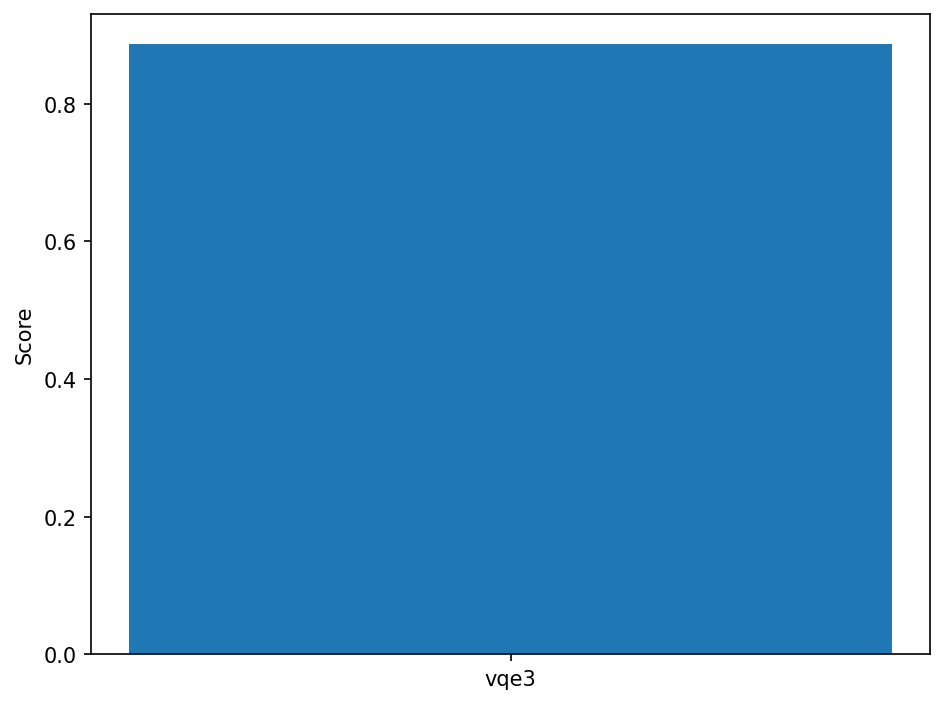

-----------------------------------------------------------
USED BACKEND:: fake_bogota ; CIRCUIT_NAME: vqe6 ; SCORE = 0.7318137059550087


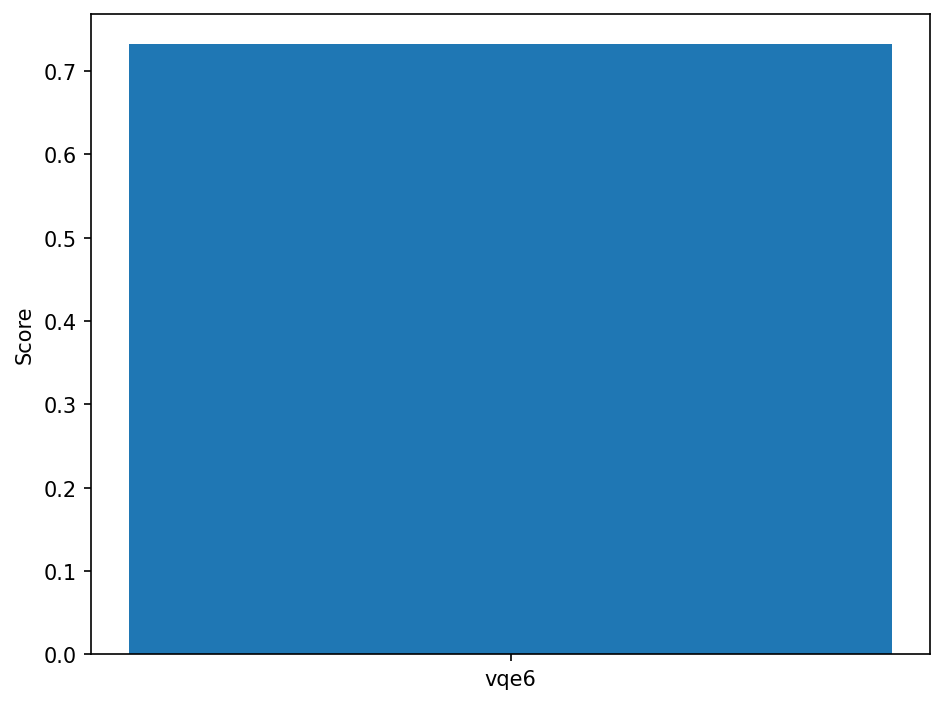

-----------------------------------------------------------
USED BACKEND:: fake_bogota ; CIRCUIT_NAME: vqe9 ; SCORE = 0.7314034350831269


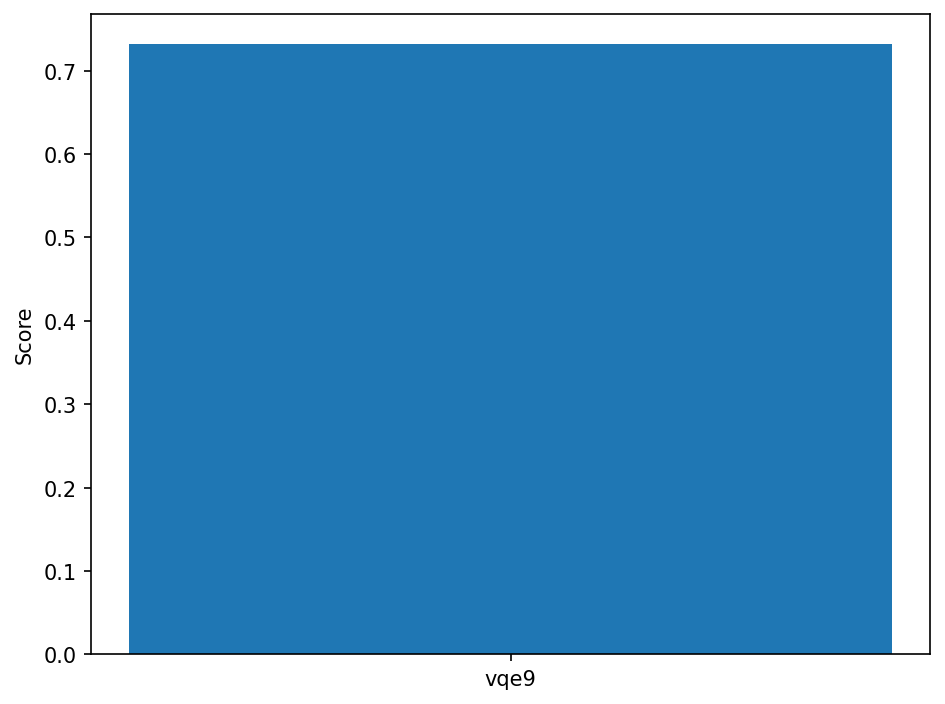

-----------------------------------------------------------
USED BACKEND:: fake_essex ; CIRCUIT_NAME: vqe3 ; SCORE = 0.8524530148651512


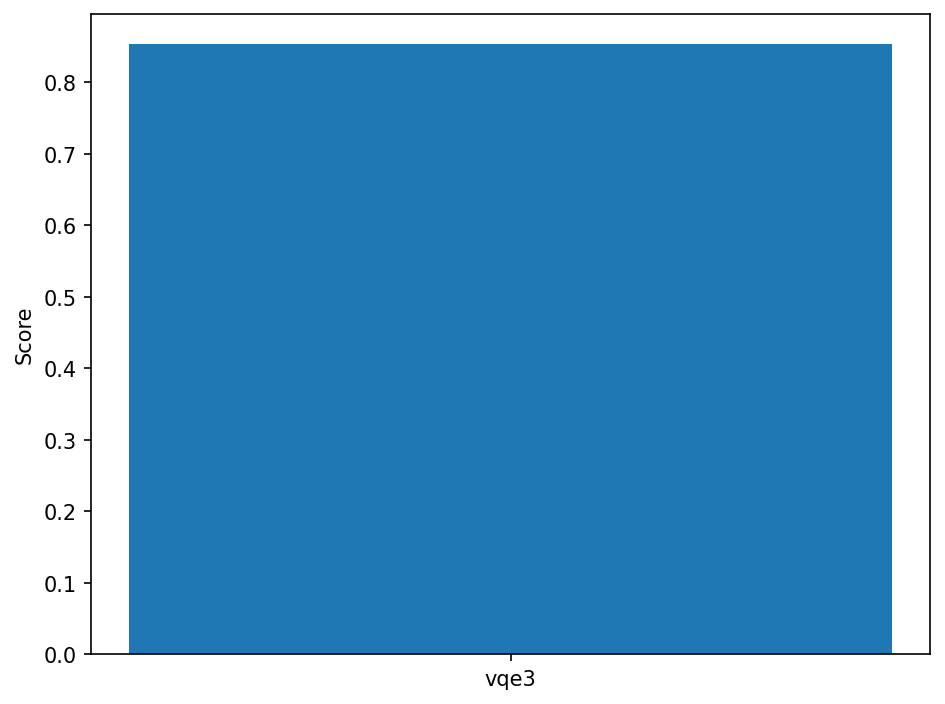

-----------------------------------------------------------
USED BACKEND:: fake_essex ; CIRCUIT_NAME: vqe6 ; SCORE = 0.7761294990087829


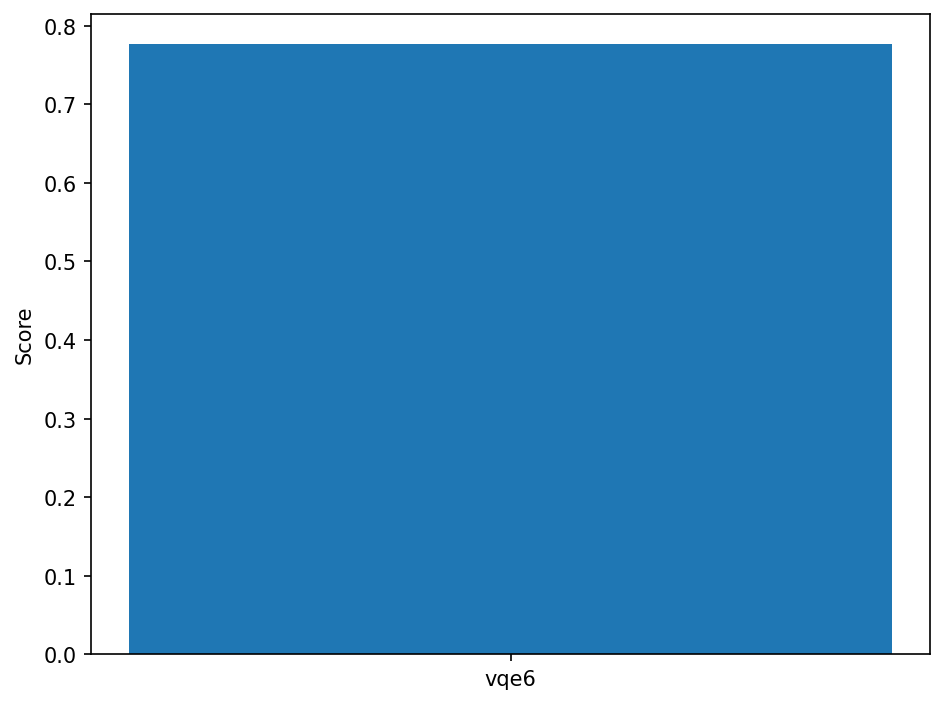

-----------------------------------------------------------
USED BACKEND:: fake_essex ; CIRCUIT_NAME: vqe9 ; SCORE = 0.7743757827377704


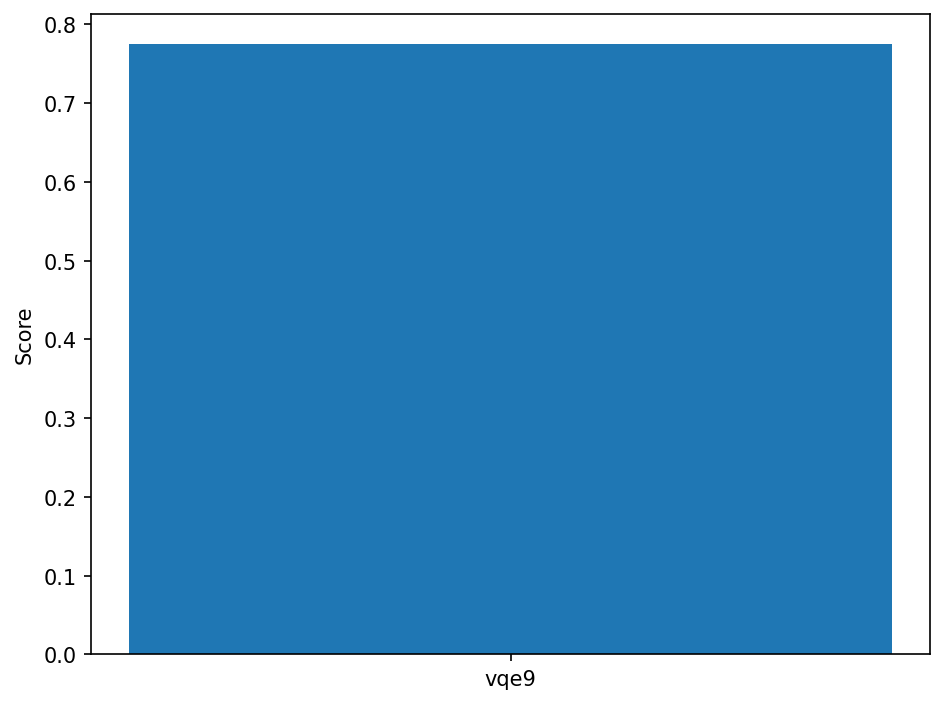

-----------------------------------------------------------
USED BACKEND:: fake_washington ; CIRCUIT_NAME: vqe3 ; SCORE = 0.9480489324599495


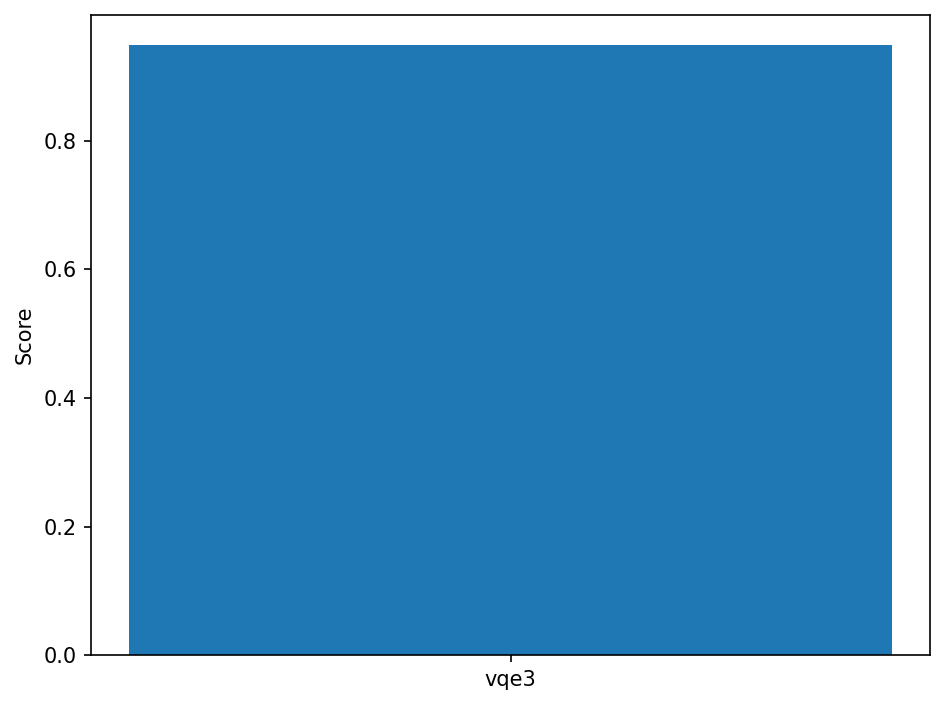

-----------------------------------------------------------
USED BACKEND:: fake_washington ; CIRCUIT_NAME: vqe6 ; SCORE = 0.6860312713173629


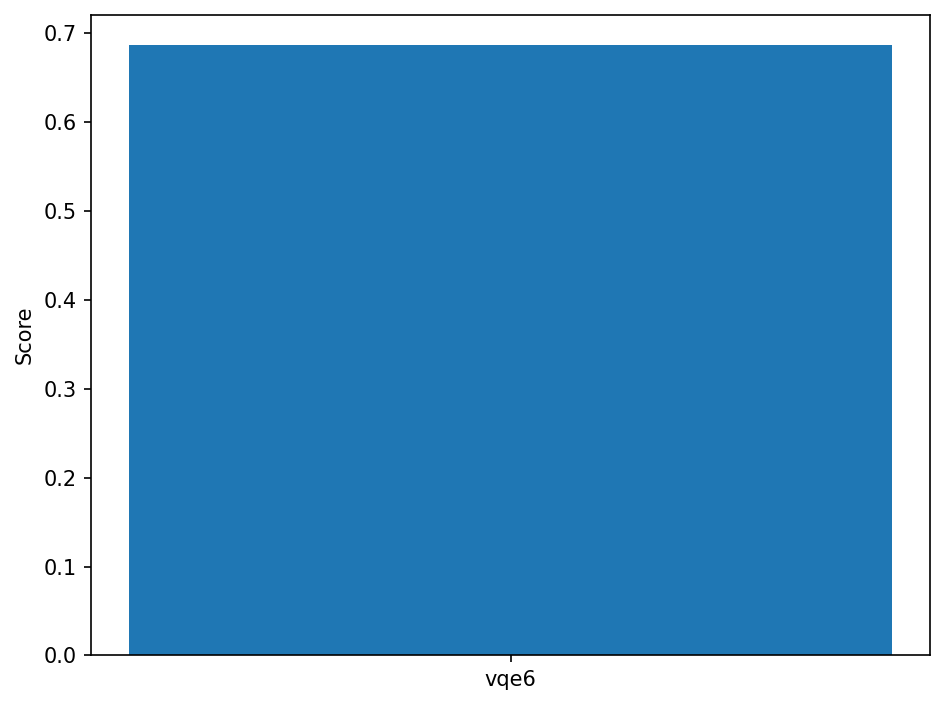

-----------------------------------------------------------
USED BACKEND:: fake_washington ; CIRCUIT_NAME: vqe9 ; SCORE = 0.6504948779112791


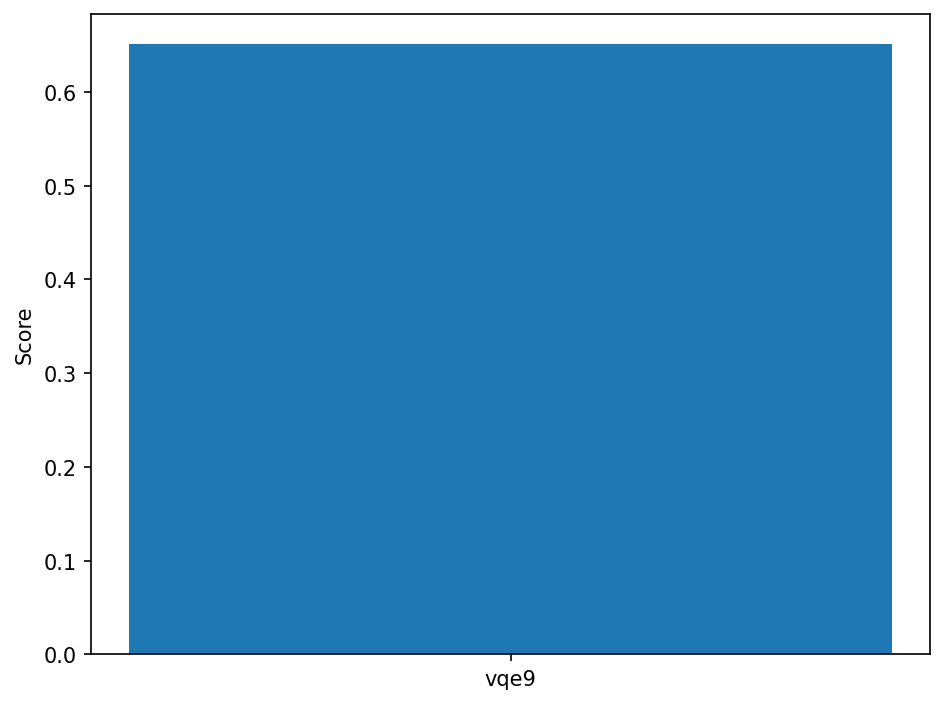

-----------------------------------------------------------
USED BACKEND:: fake_yorktown ; CIRCUIT_NAME: vqe3 ; SCORE = 0.7846972763745661


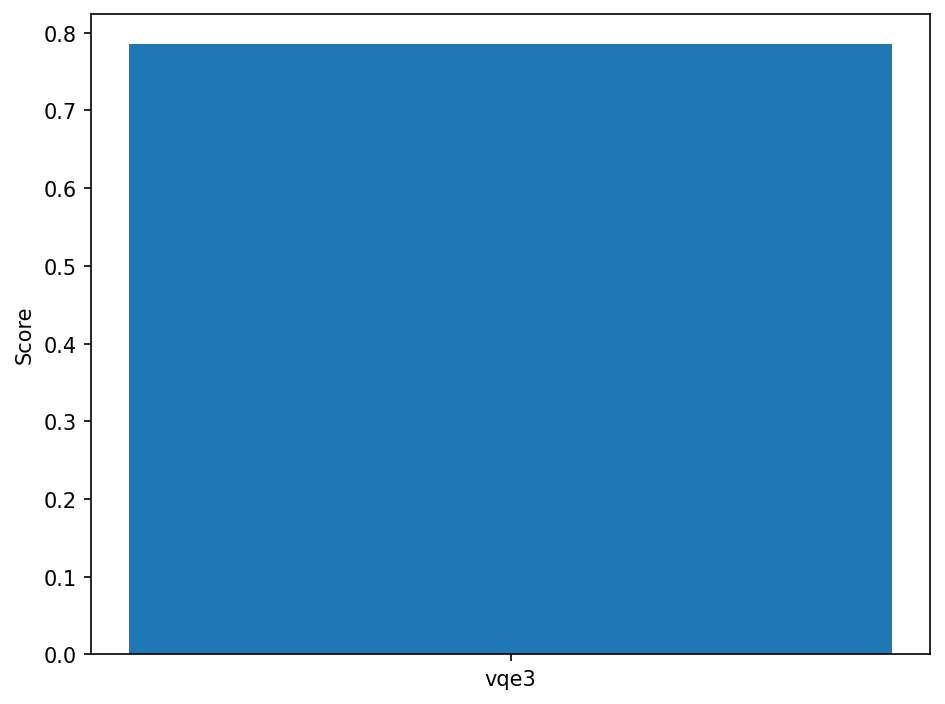

-----------------------------------------------------------
USED BACKEND:: fake_yorktown ; CIRCUIT_NAME: vqe6 ; SCORE = 0.5277563318969835


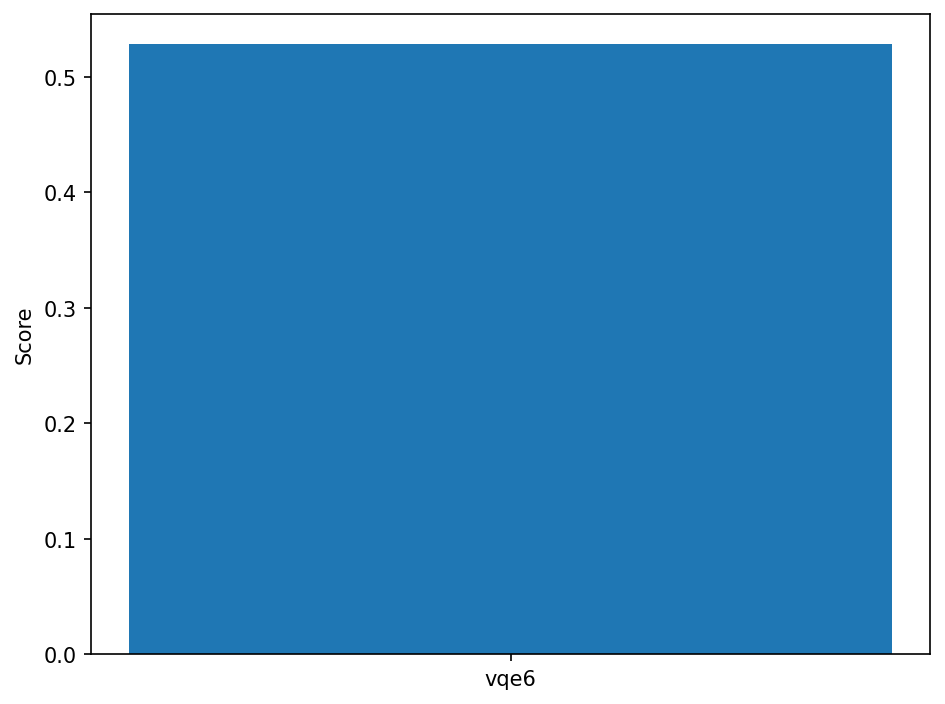

-----------------------------------------------------------
USED BACKEND:: fake_yorktown ; CIRCUIT_NAME: vqe9 ; SCORE = 0.5186244611730557


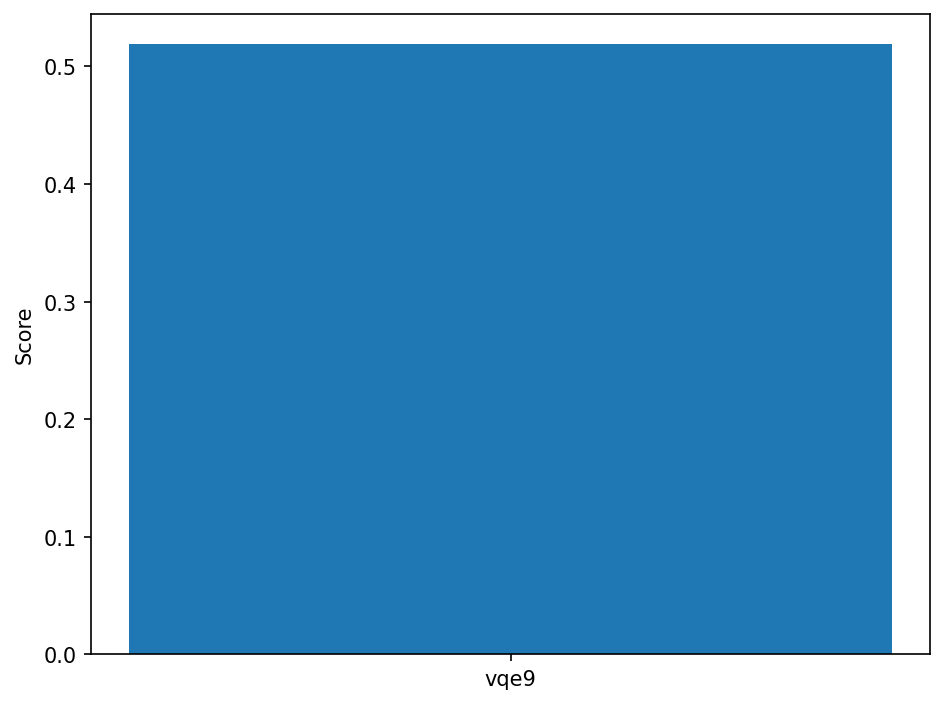

-----------------------------------------------------------
USED BACKEND:: fake_armonk ; CIRCUIT_NAME: vqe3 ; SCORE = 0.9772345276376792


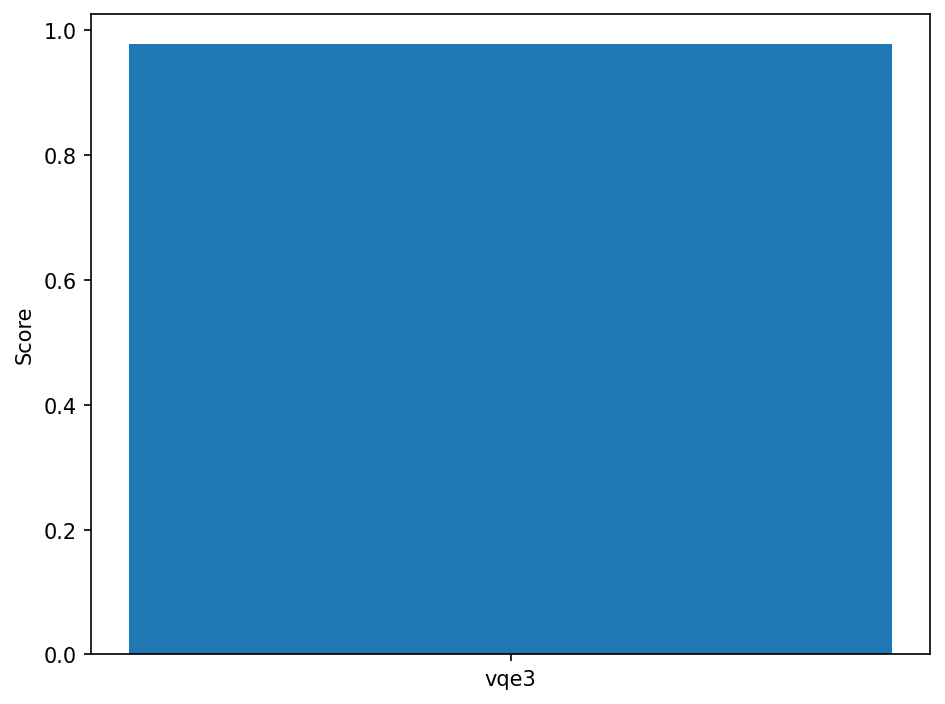

-----------------------------------------------------------
USED BACKEND:: fake_armonk ; CIRCUIT_NAME: vqe6 ; SCORE = 0.9773157323089154


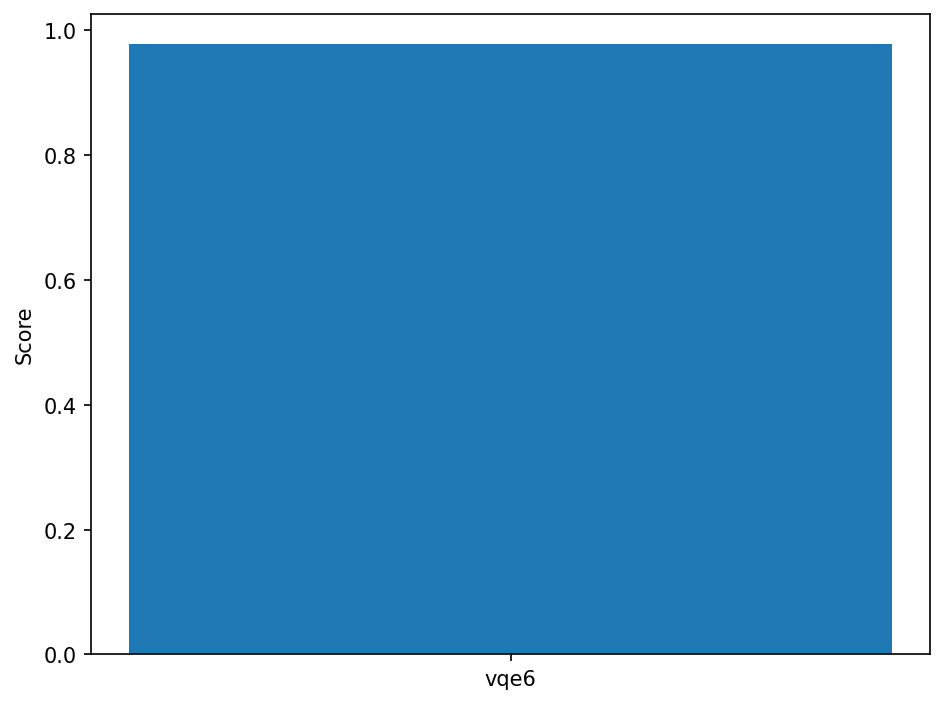

-----------------------------------------------------------
USED BACKEND:: fake_armonk ; CIRCUIT_NAME: vqe9 ; SCORE = 0.9765537764749848


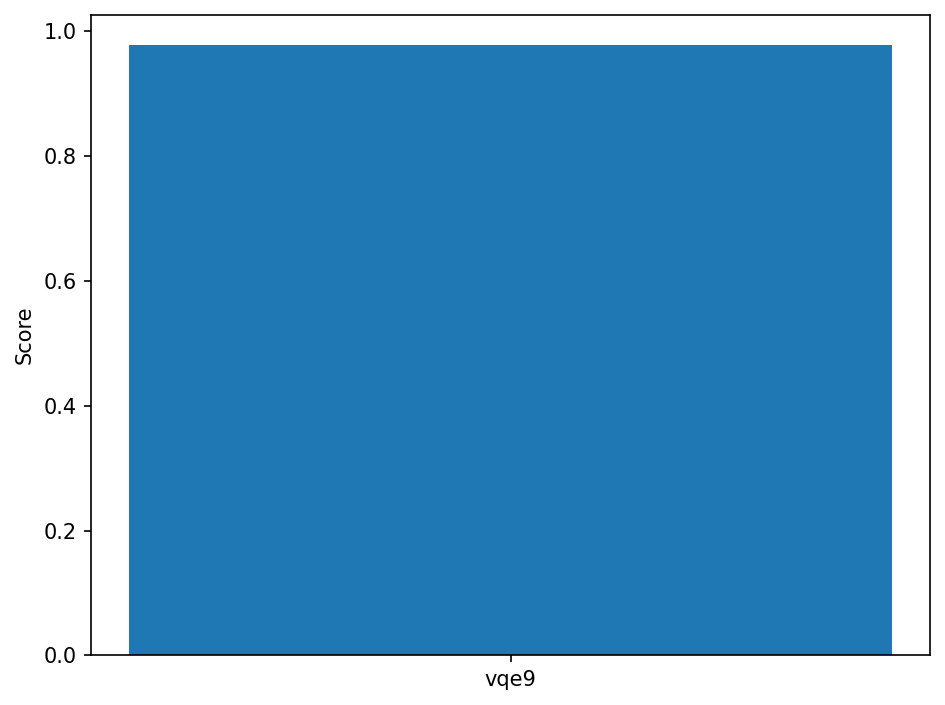

-----------------------------------------------------------


In [7]:
for label,benchmark,backend,job,score,sd in jobs:
    print("USED BACKEND::",backend().name,"; CIRCUIT_NAME:",label, "; SCORE =",score)
    supermarq.plotting.plot_results([score], [label])
    print("-----------------------------------------------------------")

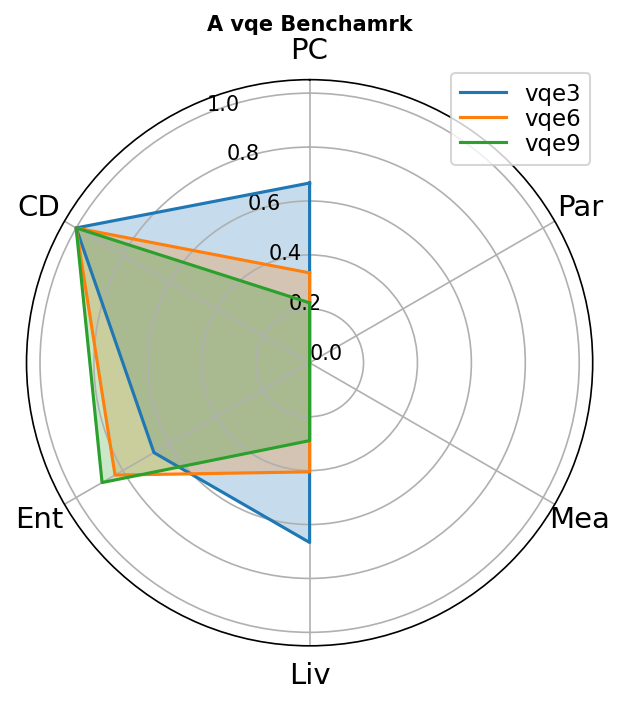

In [8]:
names=[]
scores=[]
X="A "+name_of_algo+' Benchamrk'
for i,j in benchmark_features.items():
    names.append(i)
    scores.append(j)
supermarq.plotting.plot_benchmark([X,names,scores],
        spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],show=True)

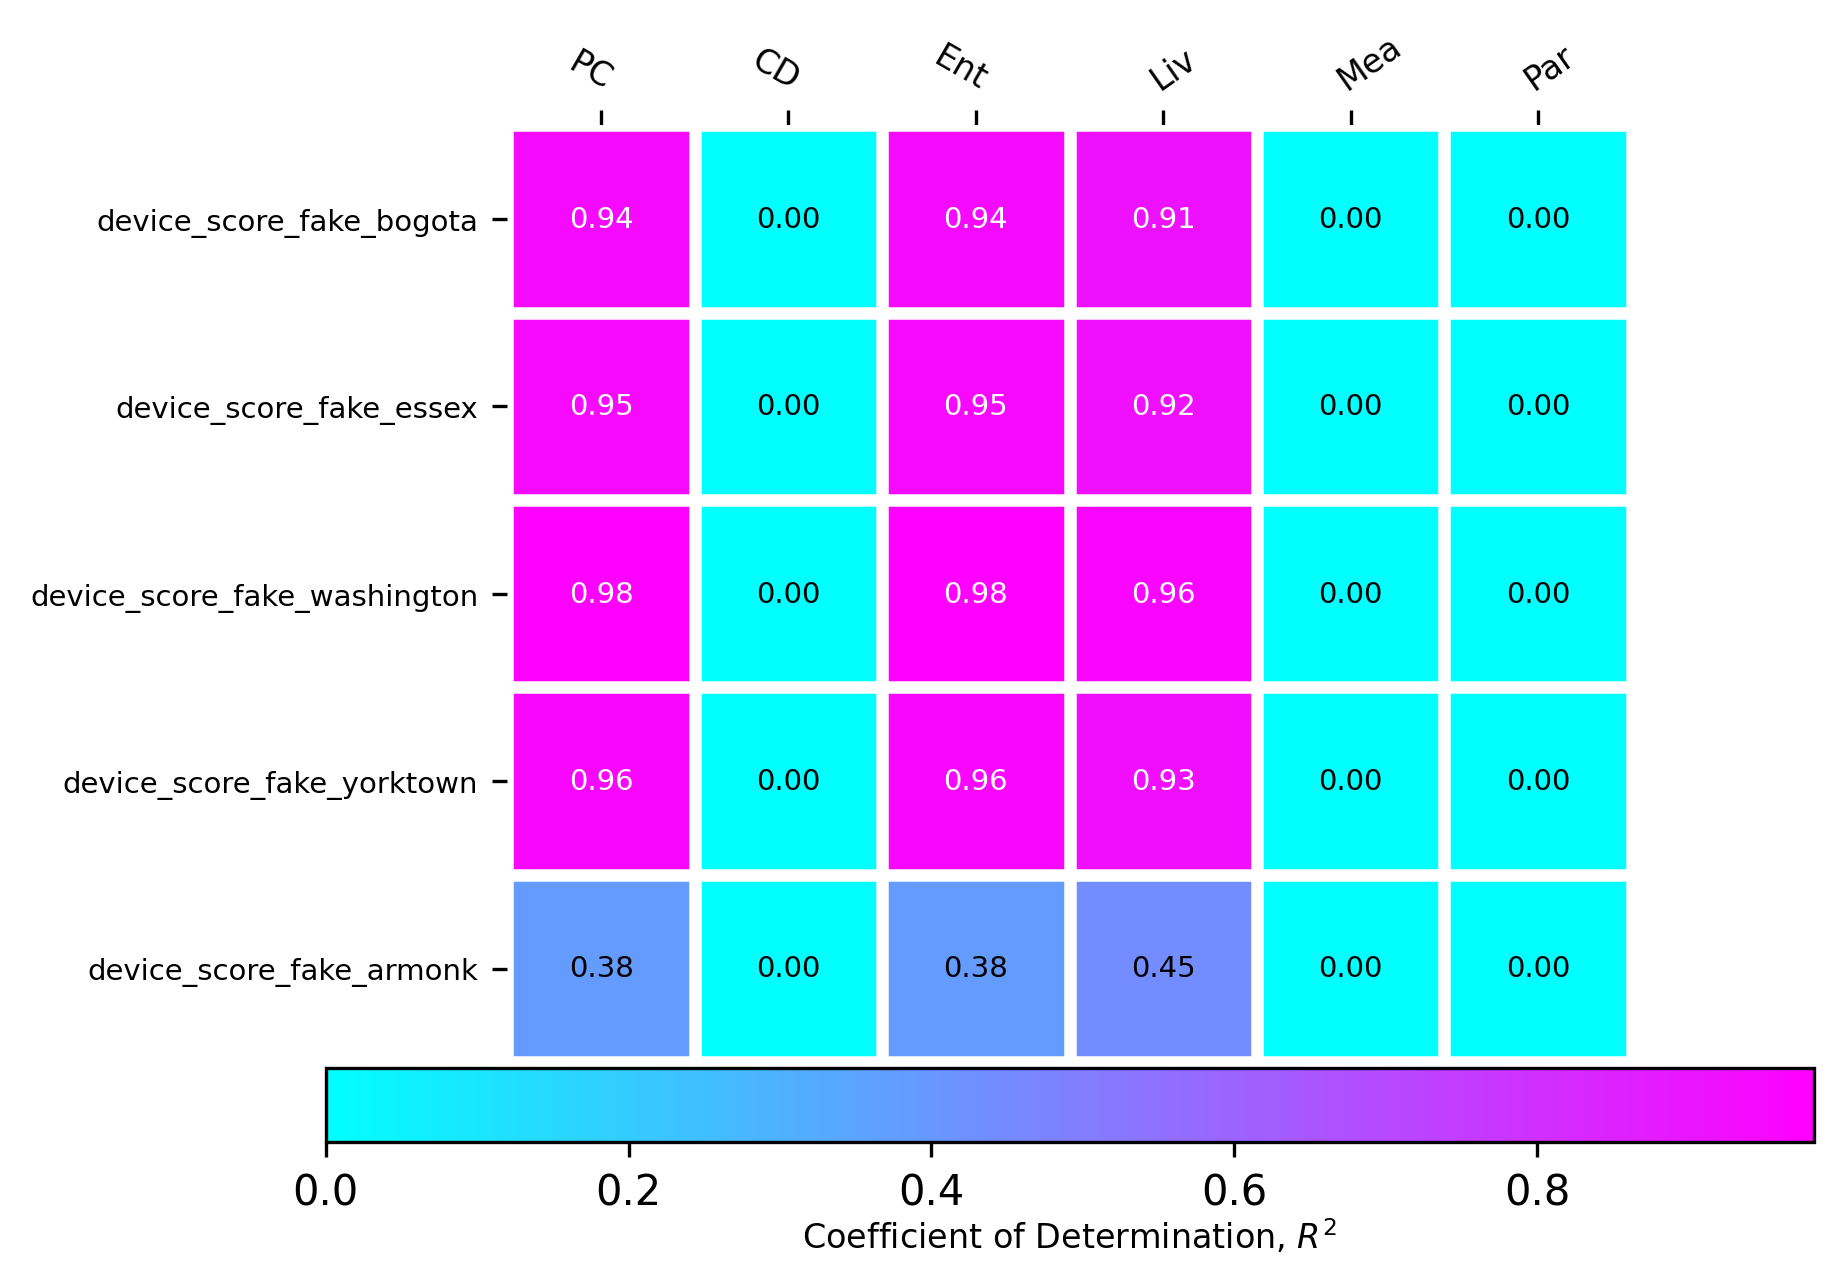

In [9]:
supermarq.plotting.plot_correlations(benchmark_features,all_fake_scores,["PC", "CD", "Ent", "Liv", "Mea", "Par"],device_name=all_fake_names,show=True,)

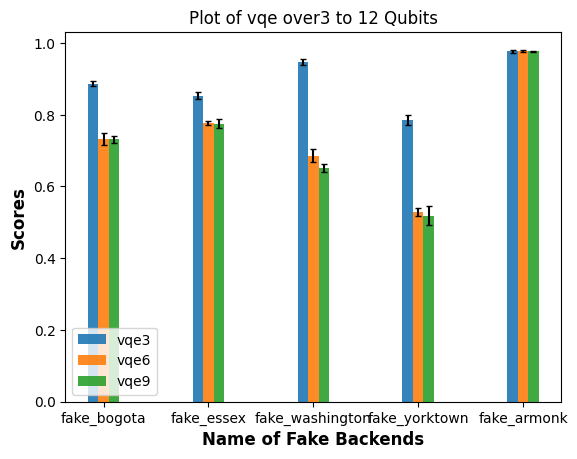

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
all_fake_names=[]
all_score=[]
all_sd=[]
all_ckt=[]
v='Plot of '+name_of_algo+' over'+str(lower_limit)+' to '+str(upper_limit)+ ' Qubits'
for i in selected_fakes:
    all_fake_names.append(i().name)    
for benchmark, label in benchmarks:
    i=[]
    j=[]
    k=[]
    for ckt,benchmark,backend,job,score,sd in jobs:
        if ckt == label:
            i.append(score)
            j.append(sd)
    all_ckt.append(label)
    all_score.append(i)
    all_sd.append(j)
num_bars = len(all_score)
width = 0.1
x = np.arange(len(all_fake_names)) # x-axis positions for each bar
fig, ax = plt.subplots()
for i in range(num_bars):               # Create bars for each category with appropriate offsets
    ax.bar(x + i * width, all_score[i], width=width, label=f'Bar {i+1}', 
           yerr=all_sd[i],align='center',alpha=0.9,ecolor='black',capsize=2)
ax.set_xlabel('Name of Fake Backends',fontweight ='bold',fontsize = 12)
ax.set_ylabel('Scores',fontweight ='bold',fontsize = 12)
ax.set_title(v)
ax.set_xticks(x + (num_bars - 1) * width / 2)
ax.set_xticklabels(all_fake_names)
ax.legend(all_ckt,loc="lower left")
#ax.grid(True)
plt.show()